<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Разделение на выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод:" data-toc-modified-id="Итоговый-вывод:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install lightgbm

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from matplotlib.pyplot import figure

#import warnings
#warnings.filterwarnings("ignore")

print("Версия LightGBM      : ", lgb.__version__)
print("Версия Scikit-Learn  : ", sklearn.__version__)

Версия LightGBM      :  3.3.5
Версия Scikit-Learn  :  1.2.2


In [3]:
try:
    df=pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df=pd.read_csv('C:/Users/zoika/OneDrive/Рабочий стол/YP ds54/projects/vremryadi/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.sort_index(inplace=True)
print(df.head(3))

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28


In [5]:
df.index.is_monotonic

True

### Подготовка данных

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.isna().mean()

num_orders    0.0
dtype: float64

### Ресемплирование

In [8]:
df=df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Тренды и сезонность

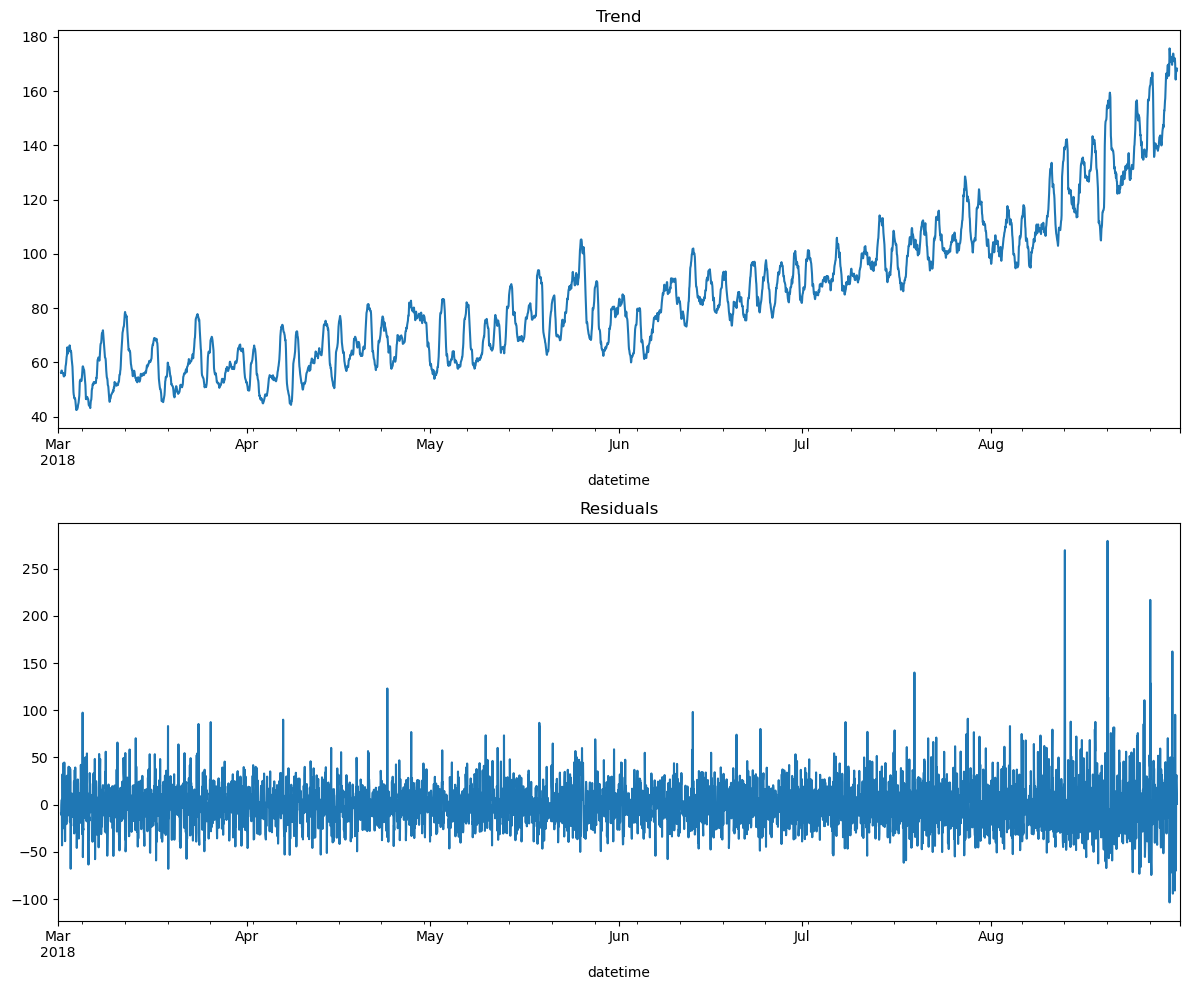

In [9]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(12, 10))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(212)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Вывод: на графике можно увидеть возрастающие тренды с мая. А чтобы понять сезонность - недостаточно данных, необходимы данные за несколько лет

### Создание признаков

In [10]:
def make_features(df, max_lag, rolling_mean_size):
    data=df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [11]:
data=make_features(df, 2, 24)

### Разделение на выборки

In [12]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train=train.dropna()

features_train=train.drop(['num_orders'],axis=1)
target_train=train['num_orders']

features_test=test.drop(['num_orders'],axis=1)
target_test=test['num_orders']

Вывод: на данном этапе мы провели предобработку данных, а именно:
- импортировали необходимые библиотеки 
- загрузили данные
- проверили пропуски
- провели ресемплирование
- создали новые признаки
- разделили данные на выборки

## Обучение

In [13]:
RMSE=make_scorer(mean_squared_error, greater_is_better=False) #для грида

### CatBoostRegressor

In [14]:
cat = CatBoostRegressor()
cat.fit(features_train, target_train,verbose=200, plot=True)
print('RMSE:',cat.best_score_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050868
0:	learn: 37.6645705	total: 57.1ms	remaining: 57s
200:	learn: 20.8526014	total: 490ms	remaining: 1.95s
400:	learn: 18.4934384	total: 927ms	remaining: 1.39s
600:	learn: 17.1179980	total: 1.41s	remaining: 939ms
800:	learn: 16.0991081	total: 1.86s	remaining: 463ms
999:	learn: 15.2086092	total: 2.38s	remaining: 0us
RMSE: {'learn': {'RMSE': 15.208609186605266}}


### LGBMRegressor

In [15]:
lgbm = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=8)

parameters_lgbm = {
    'num_leaves': range(20, 30),
    'learning_rate': [0.5, 0.7]
}

lgbm_grid = GridSearchCV(lgbm, parameters_lgbm, n_jobs=-1, scoring=RMSE , cv=tscv, verbose=10)

lgbm_grid.fit(features_train, target_train)     

Fitting 8 folds for each of 20 candidates, totalling 160 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.7],
                         'num_leaves': range(20, 30)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=10)

In [16]:
print(lgbm_grid.best_params_)
print('RMSE:',(-lgbm_grid.best_score_)**(0.5) )

{'learning_rate': 0.5, 'num_leaves': 21}
RMSE: 26.84314394120829


Вывод: лучшее значение RMSE, на обучающей выборке, получили с исползованием модели CatBoostRegressor, поэтому на тестировании будем использовать ее.

## Тестирование

In [17]:
pred_c=cat.predict(features_test)
print('RMSE:',(mean_squared_error(pred_c,target_test))**(0.5) )

RMSE: 47.006621854254846


Посмотрим на графике результаты нашего предсказания:

In [18]:
serpred = pd.Series(pred_c,index=target_test.index)

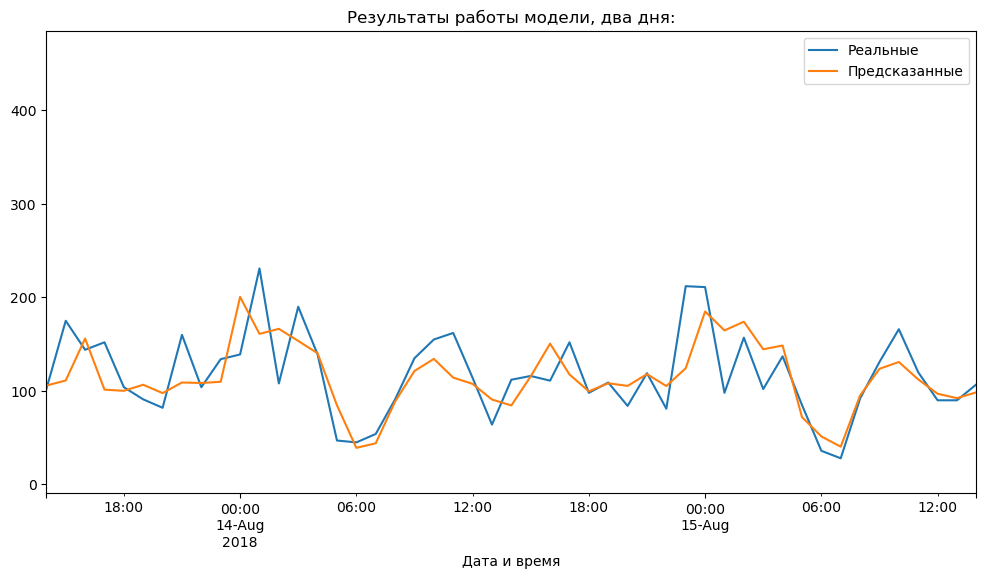

In [19]:
figure(figsize=(12, 6));
target_test.plot( label='Реальные');
serpred.plot(title='Результаты работы модели, два дня:',label='Предсказанные',xlabel='Дата и время');
plt.xlim(['2018-08-13 14:00:00','2018-08-15 14:00:00']);
plt.legend();

Вывод: на тестовых данных модель CatBoostRegressor показала хорошие результаты, значение метрики RMSE меньше 48

## Итоговый вывод:

В ходе работы над проектом были решены следующие задачи:

- импортировали необходимые библиотеки 
- загрузили данные
- проверили пропуски
- провели ресемплирование
- создали новые признаки
- разделили данные на выборки
- обучили и проверили несколько моделей
- провели перебор гиперпараметров для модели LGBMRegressor
- провели сравнение моделей, выбрали лучшую, её качество проверели на тестовой выборке

Таким образом, мы построили модель на основе CatBoostRegressor, способную спрогнозировать количество заказов такси на следующий час, не превышая заданное заказчиком значение RMSE